# 任务3：论文代码统计

## 任务说明

本次任务的主要内容是：是用正则表达式统计代码链接、页数和图表数据。

## 具体代码实现

### 数据读取

In [1]:
# 导入所需的package
import seaborn as sns #用于画图
from bs4 import BeautifulSoup #用于爬取arxiv的数据
import re #用于正则表达式，匹配字符串的模式
import requests #用于网络连接，发送网络请求，使用域名获取对应信息
import json #读取数据，我们的数据为json格式的
import pandas as pd #数据处理，数据分析
import matplotlib.pyplot as plt #画图工具

C:\Users\LWKM\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
def readArxivFile(path, columns=['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi',
       'report-no', 'categories', 'license', 'abstract', 'versions',
       'update_date', 'authors_parsed'], count=None):
    '''
    定义读取文件的函数
        path: 文件路径
        columns: 需要选择的列
        count: 读取行数
    '''
    
    data  = []
    with open(path, 'r') as f: 
        for idx, line in enumerate(f): 
            if idx == count:
                break
                
            d = json.loads(line)
            d = {col : d[col] for col in columns}
            data.append(d)

    data = pd.DataFrame(data)
    return data

# 读取本次任务需要的列
data = readArxivFile('arxiv-metadata-oai-snapshot.json', ['id', 'abstract', 'categories', 'comments'])

In [3]:
data.sample(5)

,id,abstract,categories,comments
1173719,1909.03681,High-dimensional data poses unique challenge...,cs.LG cs.AI stat.ML,None
649547,1508.02891,We investigate an electroweak interacting da...,hep-ph,"17 pages, 6 figures. v2: references added; v3:..."
1051110,1811.06477,"Language models, being at the heart of many ...",cs.NE cs.CL cs.LG,7 pages including 5 figures
87235,0810.1656,We use a new method to trace backwards the s...,astro-ph,"7 pages, 5 figures, accepted by Astron. J"
803005,1612.07196,We observe interspecies Feshbach resonances ...,cond-mat.quant-gas physics.atom-ph,"16 pages, 8 figures"


### 提取页数

In [4]:
# 正则表达式匹配
data['pages'] = data['comments'].apply(lambda x: re.findall('[1-9][0-9]* pages', str(x)))

In [5]:
# 筛选出有pages的论文
data = data[data['pages'].apply(len) > 0].reset_index(drop=True)

In [6]:
data['pages'].sample(3)

733560    [17 pages]
800530     [2 pages]
195511     [6 pages]
Name: pages, dtype: object

In [7]:
# 将pages转为数字
data['pages'] = data['pages'].apply(lambda x: float(x[0].replace(' pages','')))

In [8]:
data['pages'].sample(3)

135752    46.0
853943     5.0
686831     5.0
Name: pages, dtype: float64

统计页数的基本情况：

In [9]:
data['pages'].describe()

count    1.089180e+06
mean     1.762137e+01
std      2.245700e+01
min      1.000000e+00
25%      8.000000e+00
50%      1.300000e+01
75%      2.200000e+01
max      1.123200e+04
Name: pages, dtype: float64

In [10]:
# 上述显示效果不理想，转换为整数表示（注意上面是一个Series）
data['pages'].describe().astype(int)

count    1089180
mean          17
std           22
min            1
25%            8
50%           13
75%           22
max        11232
Name: pages, dtype: int32

分类统计页数情况。

In [11]:
# 提取论文第一个类别的主要类别
data['categories'] = data['categories'].apply(lambda x: x.split(' ')[0].split('.')[0])

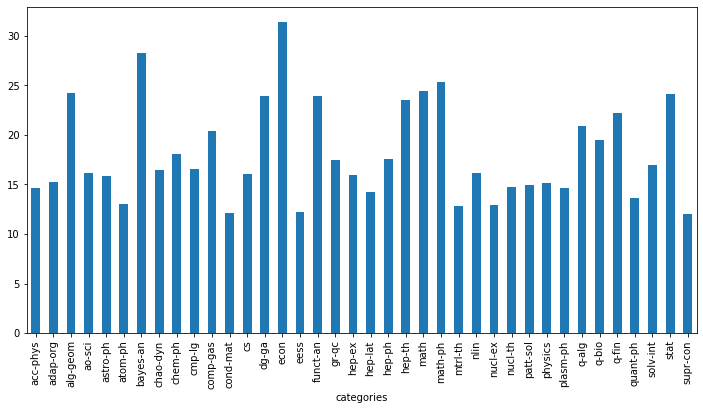

In [12]:
# 每类论文的平均页数
plt.figure(figsize = (12,6))
data.groupby(['categories'])['pages'].mean().plot(kind='bar')

### 提取图表数

In [13]:
data['figures'] = data['comments'].apply(lambda x: re.findall('[1-9][0-9]* figures', str(x)))

In [14]:
data = data[data['figures'].apply(len)>0].reset_index(drop=True)

In [15]:
data['figures'] = data['figures'].apply(lambda x: float(x[0].replace(' figures','')))

In [16]:
data.head(3)

,id,abstract,categories,comments,pages,figures
0,0704.0001,A fully differential calculation in perturba...,hep-ph,"37 pages, 15 figures; published version",37.0,15.0
1,0704.0003,The evolution of Earth-Moon system is descri...,physics,"23 pages, 3 figures",23.0,3.0
2,0704.0006,We study the two-particle wave function of p...,cond-mat,"6 pages, 4 figures, accepted by PRA",6.0,4.0


### 代码链接抽取 

In [17]:
# 筛选包含github的论文
data_with_code = data[
    (data.comments.str.contains('github')==True)|
                      (data.abstract.str.contains('github')==True)
].reset_index(drop=True)
data_with_code['text'] = data_with_code['abstract'].fillna('') + data_with_code['comments'].fillna('')


In [18]:
# 使用正则表达式匹配论文
pattern = '[a-zA-z]+://github[^\s]*'
data_with_code['code_flag'] = data_with_code['text'].str.findall(pattern).apply(len)

对论文按照类别绘图： 

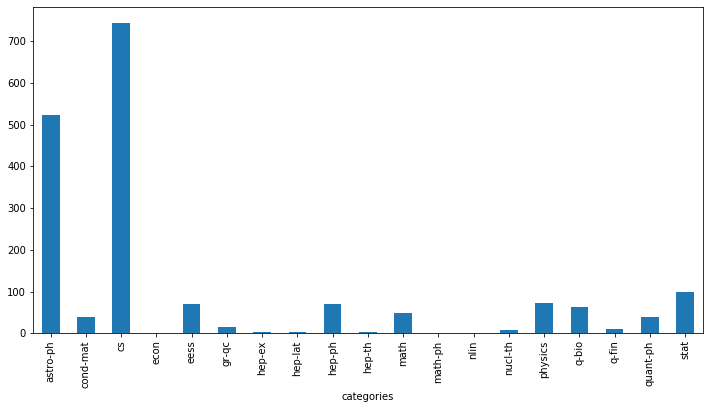

In [19]:
data_with_code = data_with_code[data_with_code['code_flag'] == 1]
plt.figure(figsize=(12, 6))
data_with_code.groupby(['categories'])['code_flag'].count().plot(kind='bar')